## Content

1. [Methods](#Methods)
2. [QUBO coefficients](#QUBO-coefficients)
3. [QUBO Hamiltonian](#QUBO-Hamiltonian)
4. [VQE ansatz](#VQE-ansatz)
5. [Parameterized Quantum Circuit](#Parameterized-Quantum-Circuit)
6. [Cost function](#Cost-function)
7. [Quantum simulator](#Quantum-simulator)

   7.1 [Case n=3](#Case-n=3)

   7.2 [Case n=6](#Case-n=6)

   7.3 [Case n=12](#Case-n=12)

### Methods

In [46]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler
from scipy.optimize import minimize

### QUBO coefficients

In [47]:
qubits = [sp.Symbol("q1"), sp.Symbol("q2"), sp.Symbol("q3")]

p1, p2, p3 = 30.0, 10.0, 90.0
N = 100.0

asset_3_prices = [p1, p2, p3]
function = -N + p1 * qubits[0] + p2 * qubits[1] +  p3 * qubits[2]
    
square_function = function**2

In [48]:
qubo_3_qb = square_function.expand()
qubo_3_qb

900.0*q1**2 + 600.0*q1*q2 + 5400.0*q1*q3 - 6000.0*q1 + 100.0*q2**2 + 1800.0*q2*q3 - 2000.0*q2 + 8100.0*q3**2 - 18000.0*q3 + 10000.0

In [49]:
def qubo_matrix(init_coeffs, cost_fun):
    
    nb_qb = len(init_coeffs)
    matrix = np.zeros((nb_qb, nb_qb))
    
    for i in range(nb_qb):
        
        matrix[i,i] = cost_fun.coeff(f"q{i + 1}**2") + cost_fun.coeff(f"q{i + 1}").args[0]
        
        for j in range(i + 1, nb_qb):
            
            matrix[i,j] = cost_fun.coeff(f"q{i + 1}*q{j + 1}")
            matrix[j,i] = cost_fun.coeff(f"q{i + 1}*q{j + 1}")
            
    return matrix

In [50]:
coeffs_3_qb = qubo_matrix(asset_3_prices, qubo_3_qb)
sp.Matrix(np.triu(coeffs_3_qb))

Matrix([
[-5100.0,   600.0,  5400.0],
[      0, -1900.0,  1800.0],
[      0,       0, -9900.0]])

In [51]:
def gate_qubo_matrix(qubo_coeffs, qubo):
    
    nb_qb = len(qubo_coeffs)
    gate_coeffs = np.zeros((nb_qb, nb_qb))
    
    constant =  qubo.args[0]
    for i in range(nb_qb):
        
        constant += 0.5 * qubo_coeffs[i,i]
        
        gate_coeffs[i,i] = -0.5 * sum(qubo_coeffs[i])
        
        for j in range(i + 1, nb_qb):
            constant += 0.25 * qubo_coeffs[i,j]
            gate_coeffs[i,j] = qubo_coeffs[i,j] / 4
    
    return [gate_coeffs, constant]

In [52]:
gate_qubo_3_qb = gate_qubo_matrix(coeffs_3_qb, qubo_3_qb)
sp.Matrix(gate_qubo_3_qb[0])

Matrix([
[-450.0,  150.0, 1350.0],
[     0, -250.0,  450.0],
[     0,      0, 1350.0]])

### QUBO Hamiltonian

In [53]:
def pauli_z_hamiltonian(coefficients):
    
    h = []
    nb_qubits = len(coefficients)
    
    for i in range(nb_qubits):
        h.append(('Z', [i], coefficients[i, i]))
        
    for i in range(nb_qubits):
        for j in range(i + 1, nb_qubits):
            h.append(("ZZ", [i,j], coefficients[i, j]))
    
    hamiltonian = SparsePauliOp.from_sparse_list(h, num_qubits = nb_qubits)
    
    return hamiltonian

In [54]:
hamiltonian_3_qb = pauli_z_hamiltonian(gate_qubo_3_qb[0])
hamiltonian_3_qb

SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[-450.+0.j, -250.+0.j, 1350.+0.j,  150.+0.j, 1350.+0.j,  450.+0.j])

### VQE ansatz

In [55]:
ansatz_3_qb = EfficientSU2(hamiltonian_3_qb.num_qubits, reps=1)

### Parameterized Quantum Circuit

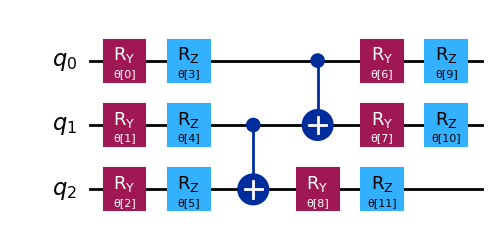

In [56]:
ansatz_3_qb.decompose().draw('mpl')

### Cost function

In [57]:
def cost_func(params, ansatz, hamiltonian, estimator):

    energy = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=1000).result().values[0]
    
    return energy

In [58]:
estimator = Estimator()

In [59]:
sampler = Sampler()

Minimize cost function using COBYLA method (gradient free)

In [60]:
x0 = 2* np.pi * np.random.random(len(ansatz_3_qb.parameters))

In [61]:
res_3_ng = minimize(cost_func, x0, args=(ansatz_3_qb, hamiltonian_3_qb, estimator), method="cobyla")

In [62]:
res_3_ng_x = np.array([3.16390393, 6.58290112, 6.5207641 , 1.81356815, 1.30940265,
       0.32527044, 3.30846516, 1.14994245, 2.9847896 , 5.30056119,
       1.84601714, 5.24764735])

#### Case n=3 

In [63]:
vqe_3_ng = ansatz_3_qb.assign_parameters(res_3_ng_x)
vqe_3_ng.measure_all()
vqe_3_ng_qs = sampler.run(vqe_3_ng, shots=1000, seed=1)

In [64]:
res_vqe_3_ng_qs = vqe_3_ng_qs.result().quasi_dists[0]

{'110': 0.684, '100': 0.286, '000': 0.01}


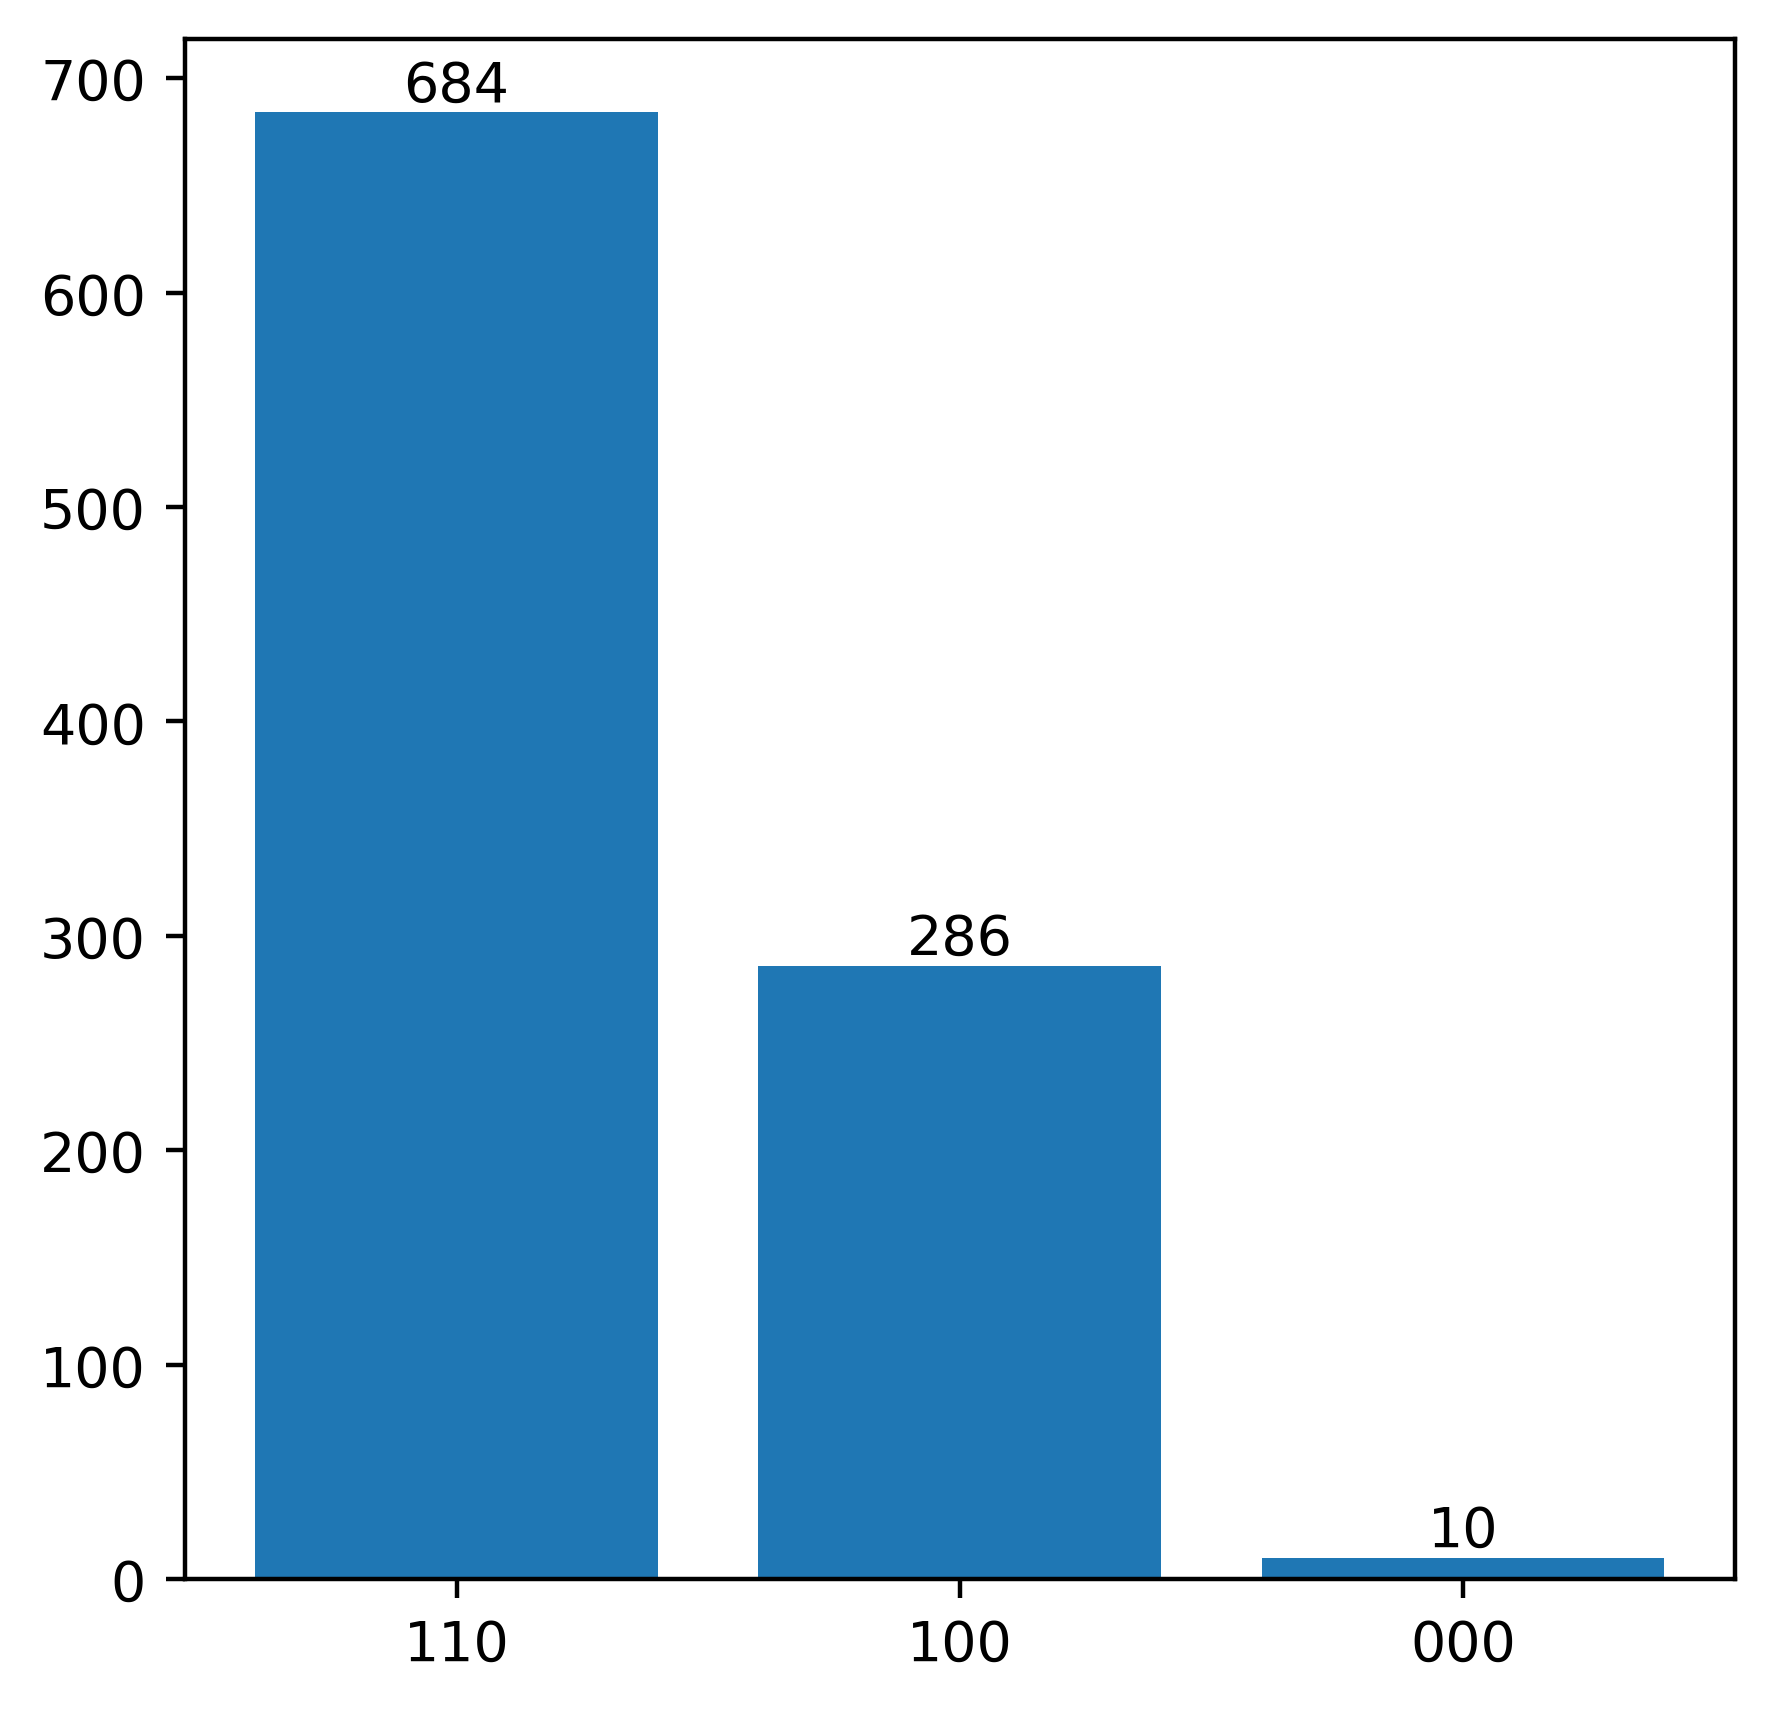

In [65]:
res_dict_3_ng = dict(list(sorted(res_vqe_3_ng_qs.binary_probabilities().items(), key=lambda item: item[1], reverse=True))[:3])
print(res_dict_3_ng)
plt.figure(figsize=(5,5), dpi=400)
round_values = [round(1000 * i) for i in res_dict_3_ng.values()]
counts = plt.bar(range(len(res_dict_3_ng)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_3_ng)), list(res_dict_3_ng.keys()))
plt.show()

#### Case n=6

In [66]:
set_seed = 3

In [67]:
n_ext = 3

np.random.seed(set_seed)

qubits = [sp.Symbol("q1"), sp.Symbol("q2"), sp.Symbol("q3")]

asset_prices = [p1, p2, p3]

function = -N + p1 * qubits[0] + p2 * qubits[1] +  p3 * qubits[2]

for i in range(n_ext):

    delta = np.random.uniform(size=1)
    price = np.ceil(200 * delta[0]) 
    asset_prices.append(price)
    qubits.append(sp.Symbol(f"q{4 + i}"))
    
    function += asset_prices[i] * sp.Symbol(f"q{4 + i}")

asset_6_prices = asset_prices

square_function = function**2

In [68]:
asset_6_prices

[30.0, 10.0, 90.0, 111.0, 142.0, 59.0]

In [69]:
qubo_6_qb = square_function.expand()
qubo_6_qb

900.0*q1**2 + 600.0*q1*q2 + 5400.0*q1*q3 + 1800.0*q1*q4 + 600.0*q1*q5 + 5400.0*q1*q6 - 6000.0*q1 + 100.0*q2**2 + 1800.0*q2*q3 + 600.0*q2*q4 + 200.0*q2*q5 + 1800.0*q2*q6 - 2000.0*q2 + 8100.0*q3**2 + 5400.0*q3*q4 + 1800.0*q3*q5 + 16200.0*q3*q6 - 18000.0*q3 + 900.0*q4**2 + 600.0*q4*q5 + 5400.0*q4*q6 - 6000.0*q4 + 100.0*q5**2 + 1800.0*q5*q6 - 2000.0*q5 + 8100.0*q6**2 - 18000.0*q6 + 10000.0

In [70]:
coeffs_6_qb = qubo_matrix(asset_6_prices, qubo_6_qb)
sp.Matrix(np.round(np.triu(coeffs_6_qb),2))

Matrix([
[-5100.0,   600.0,  5400.0,  1800.0,   600.0,  5400.0],
[      0, -1900.0,  1800.0,   600.0,   200.0,  1800.0],
[      0,       0, -9900.0,  5400.0,  1800.0, 16200.0],
[      0,       0,       0, -5100.0,   600.0,  5400.0],
[      0,       0,       0,       0, -1900.0,  1800.0],
[      0,       0,       0,       0,       0, -9900.0]])

In [71]:
gate_qubo_6_qb = gate_qubo_matrix(coeffs_6_qb, qubo_6_qb)
sp.Matrix(np.round(gate_qubo_6_qb[0],2))

Matrix([
[-4350.0,   150.0,   1350.0,   450.0,   150.0,   1350.0],
[      0, -1550.0,    450.0,   150.0,    50.0,    450.0],
[      0,       0, -10350.0,  1350.0,   450.0,   4050.0],
[      0,       0,        0, -4350.0,   150.0,   1350.0],
[      0,       0,        0,       0, -1550.0,    450.0],
[      0,       0,        0,       0,       0, -10350.0]])

In [72]:
hamiltonian_6_qb = pauli_z_hamiltonian(gate_qubo_6_qb[0])
hamiltonian_6_qb

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[ -4350.+0.j,  -1550.+0.j, -10350.+0.j,  -4350.+0.j,  -1550.+0.j,
 -10350.+0.j,    150.+0.j,   1350.+0.j,    450.+0.j,    150.+0.j,
   1350.+0.j,    450.+0.j,    150.+0.j,     50.+0.j,    450.+0.j,
   1350.+0.j,    450.+0.j,   4050.+0.j,    150.+0.j,   1350.+0.j,
    450.+0.j])

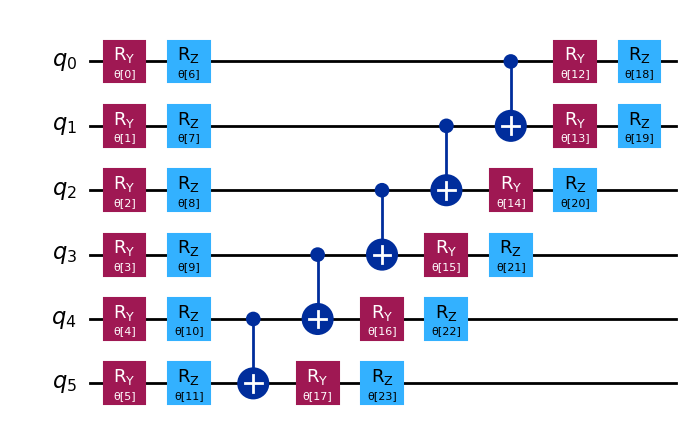

In [73]:
ansatz_6_qb = EfficientSU2(hamiltonian_6_qb.num_qubits, reps=1)
ansatz_6_qb.decompose().draw('mpl')

In [74]:
x0 = 2 * np.pi * np.random.random(len(ansatz_6_qb.parameters))

In [75]:
res_6_ng = minimize(cost_func, x0, args=(ansatz_6_qb, hamiltonian_6_qb, estimator), method="cobyla")

In [76]:
res_6_ng_x = np.array([3.37198732, 2.93296513, 3.08370596, 2.87198562, 3.18925302,
       3.25127496, 4.33710786, 4.74084558, 2.72410079, 3.15940499,
       5.45534669, 4.11428381, 3.13484137, 3.07920946, 0.08166367,
       6.32917332, 6.20178288, 6.11507437, 5.97787932, 1.06475315,
       2.5359521 , 0.28904721, 0.39489462, 2.26707295])

In [77]:
vqe_6_ng = ansatz_6_qb.assign_parameters(res_6_ng_x)
vqe_6_ng.measure_all()
vqe_6_ng_qs = sampler.run(vqe_6_ng, shots=1000, seed=1)

In [78]:
res_vqe_6_ng_qs = vqe_6_ng_qs.result().quasi_dists[0]

{'000010': 0.947, '000001': 0.019, '011010': 0.019}


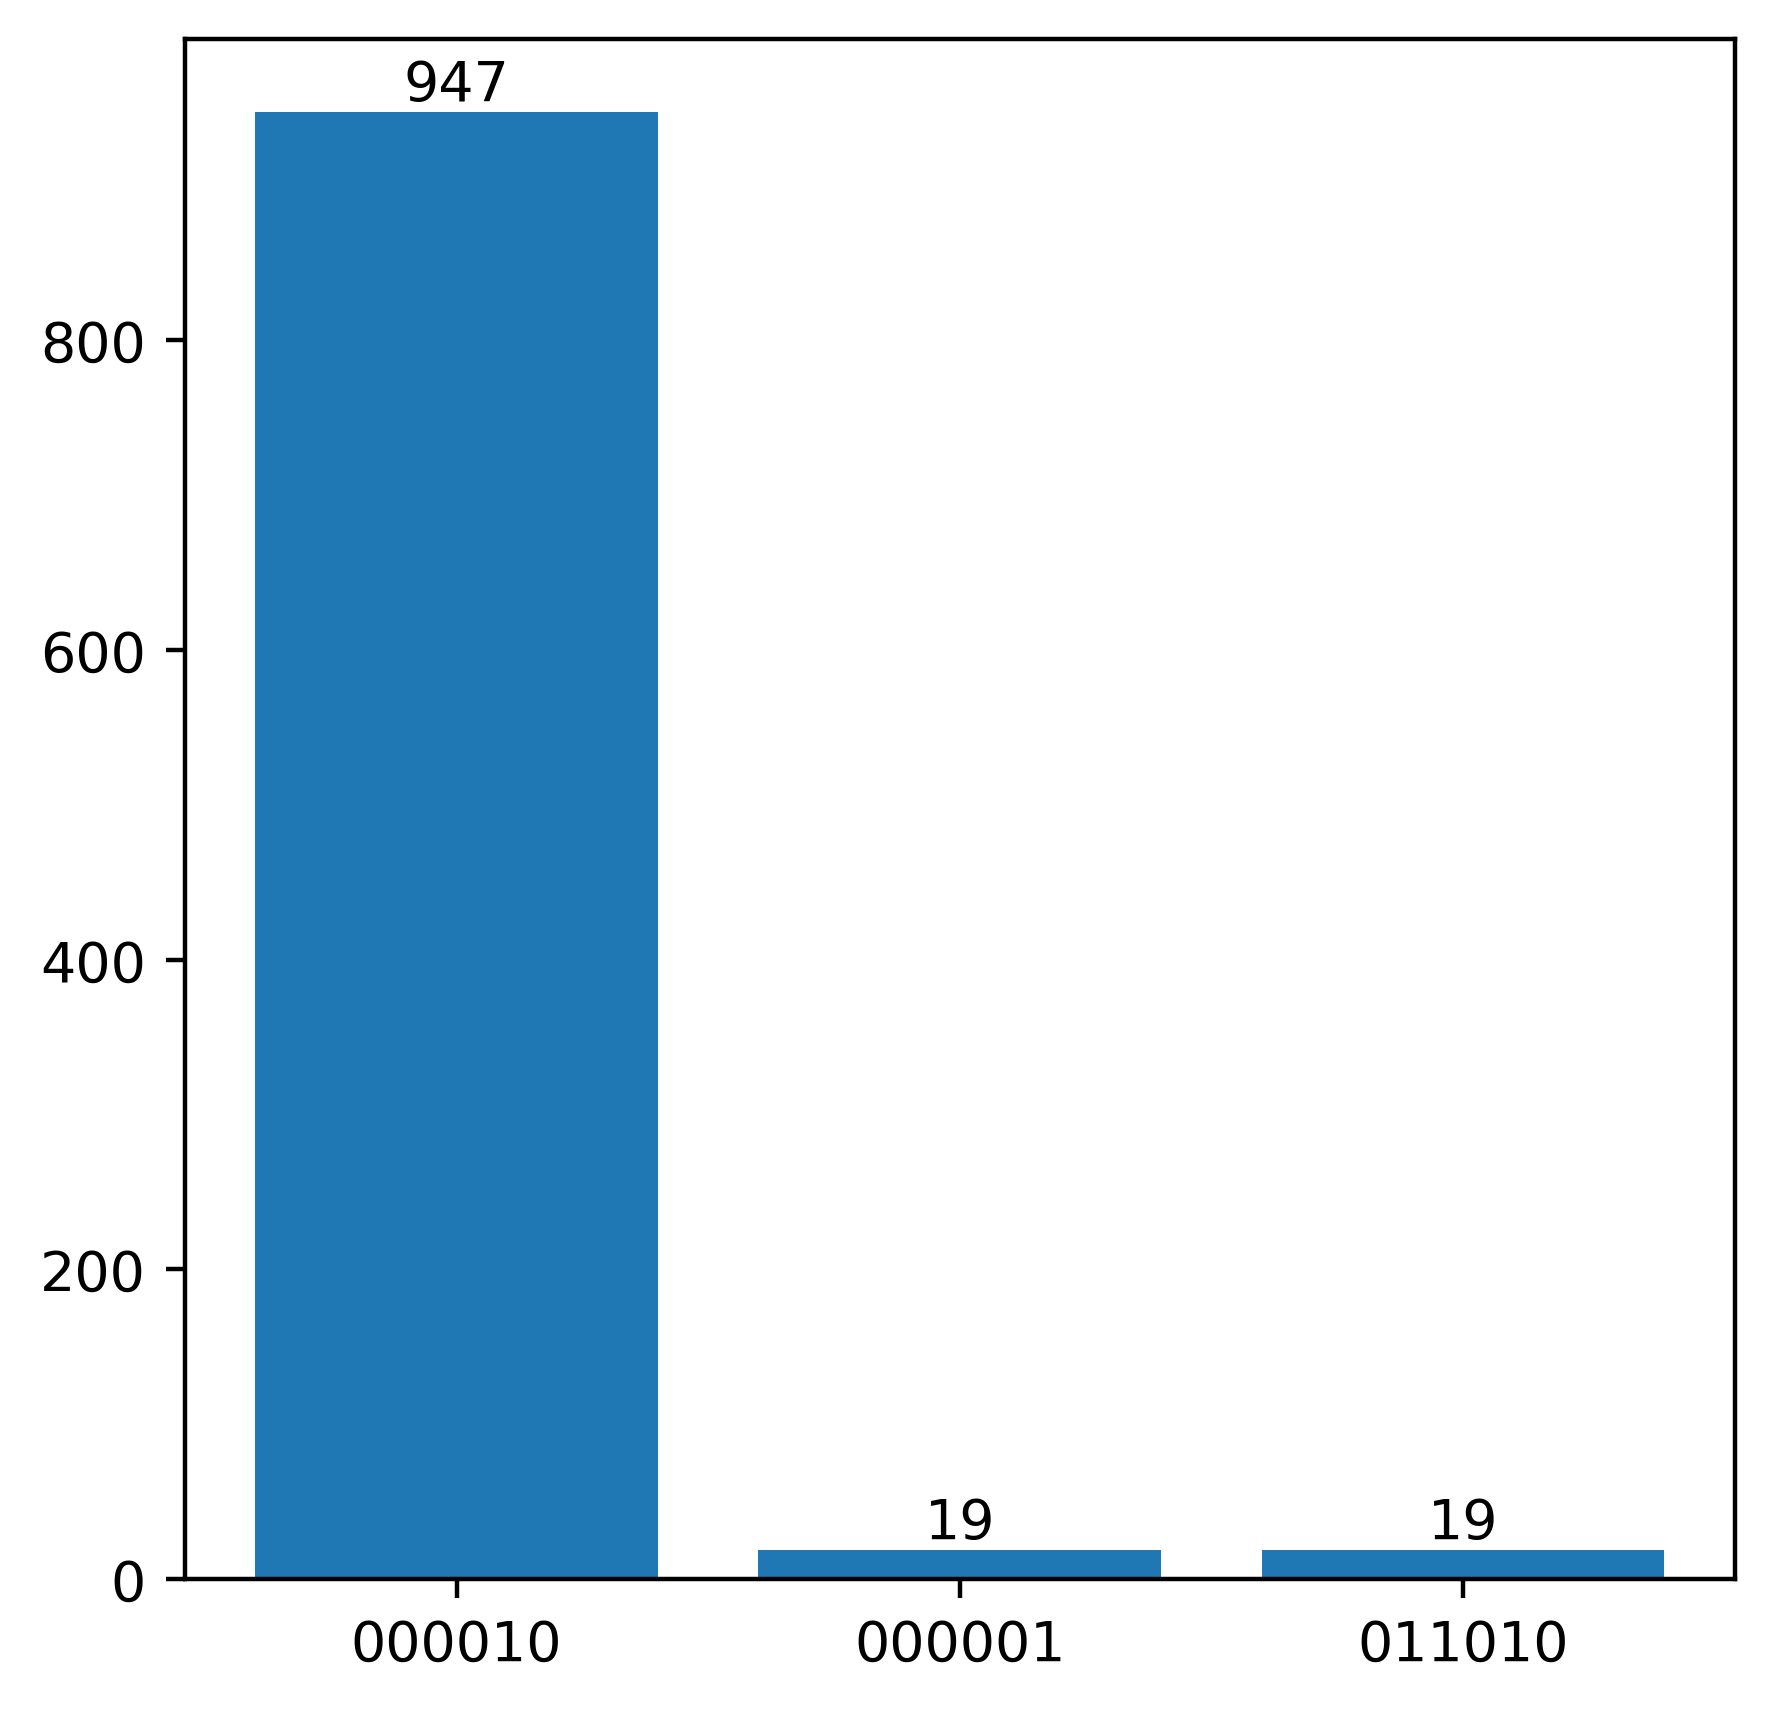

In [79]:
res_dict_6_ng = dict(list(sorted(res_vqe_6_ng_qs.binary_probabilities().items(), key=lambda item: item[1], reverse=True))[:3])
print(res_dict_6_ng)
plt.figure(figsize=(5,5), dpi=400)
round_values = [round(1000 * i) for i in res_dict_6_ng.values()]
counts = plt.bar(range(len(res_dict_6_ng)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_6_ng)), list(res_dict_6_ng.keys()))
plt.show()

In [80]:
asset_6_prices.reverse()
asset_6_prices

[59.0, 142.0, 111.0, 90.0, 10.0, 30.0]

#### Case n=12

In [81]:
n_ext = 9

np.random.seed(set_seed)

qubits = [sp.Symbol("q1"), sp.Symbol("q2"), sp.Symbol("q3")]

asset_prices = [p1, p2, p3]

function = -N + p1 * qubits[0] + p2 * qubits[1] +  p3 * qubits[2]

for i in range(n_ext):
       
    delta = np.random.uniform(size=1)
    price = np.ceil(200 * delta[0]) 
    asset_prices.append(price)
    qubits.append(sp.Symbol(f"q{4 + i}"))
    
    function += asset_prices[i] * sp.Symbol(f"q{4 + i}")
    
asset_12_prices = asset_prices

square_function = function**2

In [82]:
asset_12_prices

[30.0, 10.0, 90.0, 111.0, 142.0, 59.0, 103.0, 179.0, 180.0, 26.0, 42.0, 11.0]

In [83]:
qubo_12_qb = square_function.expand()
qubo_12_qb

900.0*q1**2 + 6180.0*q1*q10 + 10740.0*q1*q11 + 10800.0*q1*q12 + 600.0*q1*q2 + 5400.0*q1*q3 + 1800.0*q1*q4 + 600.0*q1*q5 + 5400.0*q1*q6 + 6660.0*q1*q7 + 8520.0*q1*q8 + 3540.0*q1*q9 - 6000.0*q1 + 10609.0*q10**2 + 36874.0*q10*q11 + 37080.0*q10*q12 + 2060.0*q10*q2 + 18540.0*q10*q3 + 6180.0*q10*q4 + 2060.0*q10*q5 + 18540.0*q10*q6 + 22866.0*q10*q7 + 29252.0*q10*q8 + 12154.0*q10*q9 - 20600.0*q10 + 32041.0*q11**2 + 64440.0*q11*q12 + 3580.0*q11*q2 + 32220.0*q11*q3 + 10740.0*q11*q4 + 3580.0*q11*q5 + 32220.0*q11*q6 + 39738.0*q11*q7 + 50836.0*q11*q8 + 21122.0*q11*q9 - 35800.0*q11 + 32400.0*q12**2 + 3600.0*q12*q2 + 32400.0*q12*q3 + 10800.0*q12*q4 + 3600.0*q12*q5 + 32400.0*q12*q6 + 39960.0*q12*q7 + 51120.0*q12*q8 + 21240.0*q12*q9 - 36000.0*q12 + 100.0*q2**2 + 1800.0*q2*q3 + 600.0*q2*q4 + 200.0*q2*q5 + 1800.0*q2*q6 + 2220.0*q2*q7 + 2840.0*q2*q8 + 1180.0*q2*q9 - 2000.0*q2 + 8100.0*q3**2 + 5400.0*q3*q4 + 1800.0*q3*q5 + 16200.0*q3*q6 + 19980.0*q3*q7 + 25560.0*q3*q8 + 10620.0*q3*q9 - 18000.0*q3 + 900.0*q

In [84]:
coeffs_12_qb = qubo_matrix(asset_12_prices, qubo_12_qb)
sp.Matrix(np.round(np.triu(coeffs_12_qb), 2))

Matrix([
[-5100.0,   600.0,  5400.0,  1800.0,   600.0,  5400.0,  6660.0,  8520.0,  3540.0,  6180.0, 10740.0, 10800.0],
[      0, -1900.0,  1800.0,   600.0,   200.0,  1800.0,  2220.0,  2840.0,  1180.0,  2060.0,  3580.0,  3600.0],
[      0,       0, -9900.0,  5400.0,  1800.0, 16200.0, 19980.0, 25560.0, 10620.0, 18540.0, 32220.0, 32400.0],
[      0,       0,       0, -5100.0,   600.0,  5400.0,  6660.0,  8520.0,  3540.0,  6180.0, 10740.0, 10800.0],
[      0,       0,       0,       0, -1900.0,  1800.0,  2220.0,  2840.0,  1180.0,  2060.0,  3580.0,  3600.0],
[      0,       0,       0,       0,       0, -9900.0, 19980.0, 25560.0, 10620.0, 18540.0, 32220.0, 32400.0],
[      0,       0,       0,       0,       0,       0, -9879.0, 31524.0, 13098.0, 22866.0, 39738.0, 39960.0],
[      0,       0,       0,       0,       0,       0,       0, -8236.0, 16756.0, 29252.0, 50836.0, 51120.0],
[      0,       0,       0,       0,       0,       0,       0,       0, -8319.0, 12154.0, 21122.0, 21240.0],
[

In [85]:
gate_qubo_12_qb = gate_qubo_matrix(coeffs_12_qb, qubo_12_qb)
sp.Matrix(np.round(gate_qubo_12_qb[0],2))

Matrix([
[-27570.0,   150.0,   1350.0,    450.0,   150.0,   1350.0,   1665.0,    2130.0,    885.0,   1545.0,    2685.0,    2700.0],
[       0, -9290.0,    450.0,    150.0,    50.0,    450.0,    555.0,     710.0,    295.0,    515.0,     895.0,     900.0],
[       0,       0, -80010.0,   1350.0,   450.0,   4050.0,   4995.0,    6390.0,   2655.0,   4635.0,    8055.0,    8100.0],
[       0,       0,        0, -27570.0,   150.0,   1350.0,   1665.0,    2130.0,    885.0,   1545.0,    2685.0,    2700.0],
[       0,       0,        0,        0, -9290.0,    450.0,    555.0,     710.0,    295.0,    515.0,     895.0,     900.0],
[       0,       0,        0,        0,       0, -80010.0,   4995.0,    6390.0,   2655.0,   4635.0,    8055.0,    8100.0],
[       0,       0,        0,        0,       0,        0, -97513.5,    7881.0,   3274.5,   5716.5,    9934.5,    9990.0],
[       0,       0,        0,        0,       0,        0,        0, -122546.0,   4189.0,   7313.0,   12709.0,   12780.0],
[      

In [86]:
hamiltonian_12_qb = pauli_z_hamiltonian(gate_qubo_12_qb[0])
hamiltonian_12_qb

SparsePauliOp(['IIIIIIIIIIIZ', 'IIIIIIIIIIZI', 'IIIIIIIIIZII', 'IIIIIIIIZIII', 'IIIIIIIZIIII', 'IIIIIIZIIIII', 'IIIIIZIIIIII', 'IIIIZIIIIIII', 'IIIZIIIIIIII', 'IIZIIIIIIIII', 'IZIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIIIIIZZ', 'IIIIIIIIIZIZ', 'IIIIIIIIZIIZ', 'IIIIIIIZIIIZ', 'IIIIIIZIIIIZ', 'IIIIIZIIIIIZ', 'IIIIZIIIIIIZ', 'IIIZIIIIIIIZ', 'IIZIIIIIIIIZ', 'IZIIIIIIIIIZ', 'ZIIIIIIIIIIZ', 'IIIIIIIIIZZI', 'IIIIIIIIZIZI', 'IIIIIIIZIIZI', 'IIIIIIZIIIZI', 'IIIIIZIIIIZI', 'IIIIZIIIIIZI', 'IIIZIIIIIIZI', 'IIZIIIIIIIZI', 'IZIIIIIIIIZI', 'ZIIIIIIIIIZI', 'IIIIIIIIZZII', 'IIIIIIIZIZII', 'IIIIIIZIIZII', 'IIIIIZIIIZII', 'IIIIZIIIIZII', 'IIIZIIIIIZII', 'IIZIIIIIIZII', 'IZIIIIIIIZII', 'ZIIIIIIIIZII', 'IIIIIIIZZIII', 'IIIIIIZIZIII', 'IIIIIZIIZIII', 'IIIIZIIIZIII', 'IIIZIIIIZIII', 'IIZIIIIIZIII', 'IZIIIIIIZIII', 'ZIIIIIIIZIII', 'IIIIIIZZIIII', 'IIIIIZIZIIII', 'IIIIZIIZIIII', 'IIIZIIIZIIII', 'IIZIIIIZIIII', 'IZIIIIIZIIII', 'ZIIIIIIZIIII', 'IIIIIZZIIIII', 'IIIIZIZIIIII', 'IIIZIIZIIIII', 'IIZIIIZIIIII', 'IZIIIIZI

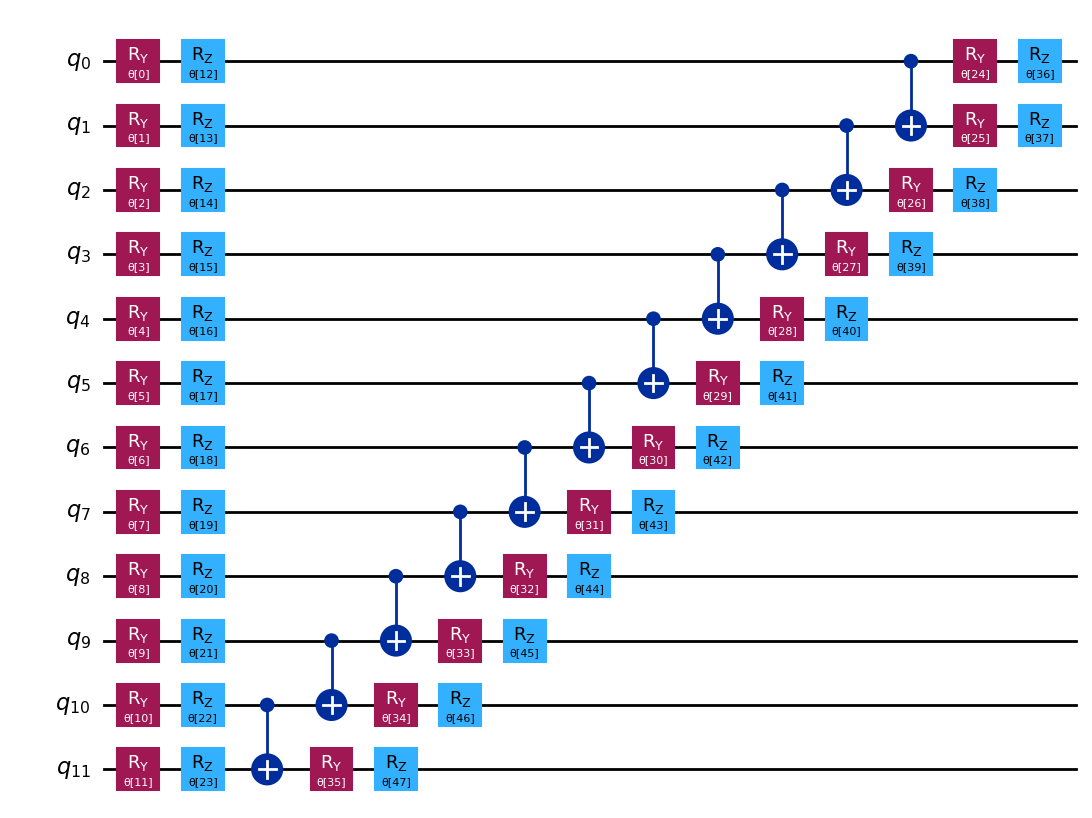

In [87]:
ansatz_12_qb = EfficientSU2(hamiltonian_12_qb.num_qubits, reps=1)
ansatz_12_qb.decompose().draw('mpl')

In [88]:
x0 = 2 * np.pi * np.random.random(len(ansatz_12_qb.parameters))

In [89]:
res_vqe_12_qb_ng = minimize(cost_func, x0, args=(ansatz_12_qb, hamiltonian_12_qb, estimator), method="cobyla")

In [90]:
res_vqe_12_qb_ng_x = np.array([7.00835382e+00,  6.26815822e+00,  6.50172145e+00,  3.35560327e+00,
       -4.45371733e-02,  3.21598284e+00,  6.39441401e+00,  6.33658459e+00,
        3.21216021e+00,  3.16741571e+00,  3.37466272e-03,  6.22287889e+00,
        2.63761592e+00,  6.51825664e+00,  2.97344769e+00,  5.86038540e+00,
        3.74480810e+00,  5.57595817e+00,  7.67435384e-02,  2.40222941e+00,
        7.60322804e-01,  3.09352310e+00,  4.37746162e+00,  3.83769966e+00,
        3.67315873e+00,  5.52253064e+00,  6.05437397e-02,  3.43231470e+00,
        4.03771659e+00,  3.19756439e+00,  3.08342582e+00,  6.20464456e+00,
        2.51533805e+00,  6.22806310e+00,  3.20641100e+00, -1.72130100e-02,
        3.96923744e+00,  1.25362362e+00,  4.38415574e+00,  4.17355189e+00,
        5.96536601e+00,  4.45868216e+00,  2.30501122e+00,  4.22990815e-01,
        1.64071462e+00, -4.52436297e-01,  3.46509817e+00, -1.12453753e-01])

In [91]:
vqe_12_ng = ansatz_12_qb.assign_parameters(res_vqe_12_qb_ng_x)
vqe_12_ng.measure_all()
vqe_12_ng_qs = sampler.run(vqe_12_ng, shots=1000, seed=1)

In [92]:
res_vqe_12_ng_qs = vqe_12_ng_qs.result().quasi_dists[0]

In [93]:
bit_str = max(res_vqe_12_ng_qs.binary_probabilities(), key=res_vqe_12_ng_qs.binary_probabilities().get)
prob = res_vqe_12_ng_qs.binary_probabilities()[bit_str]
print((bit_str, prob))

('000000000001', 0.564)


In [94]:
res_dict_12_ng = dict(list(sorted(res_vqe_12_ng_qs.binary_probabilities().items(), key=lambda item: item[1], reverse=True))[:3])
print(res_dict_12_ng)

{'000000000001': 0.564, '000000000010': 0.12, '000000010001': 0.113}


{'000000000001': 0.564, '000000000010': 0.12, '000000010001': 0.113}


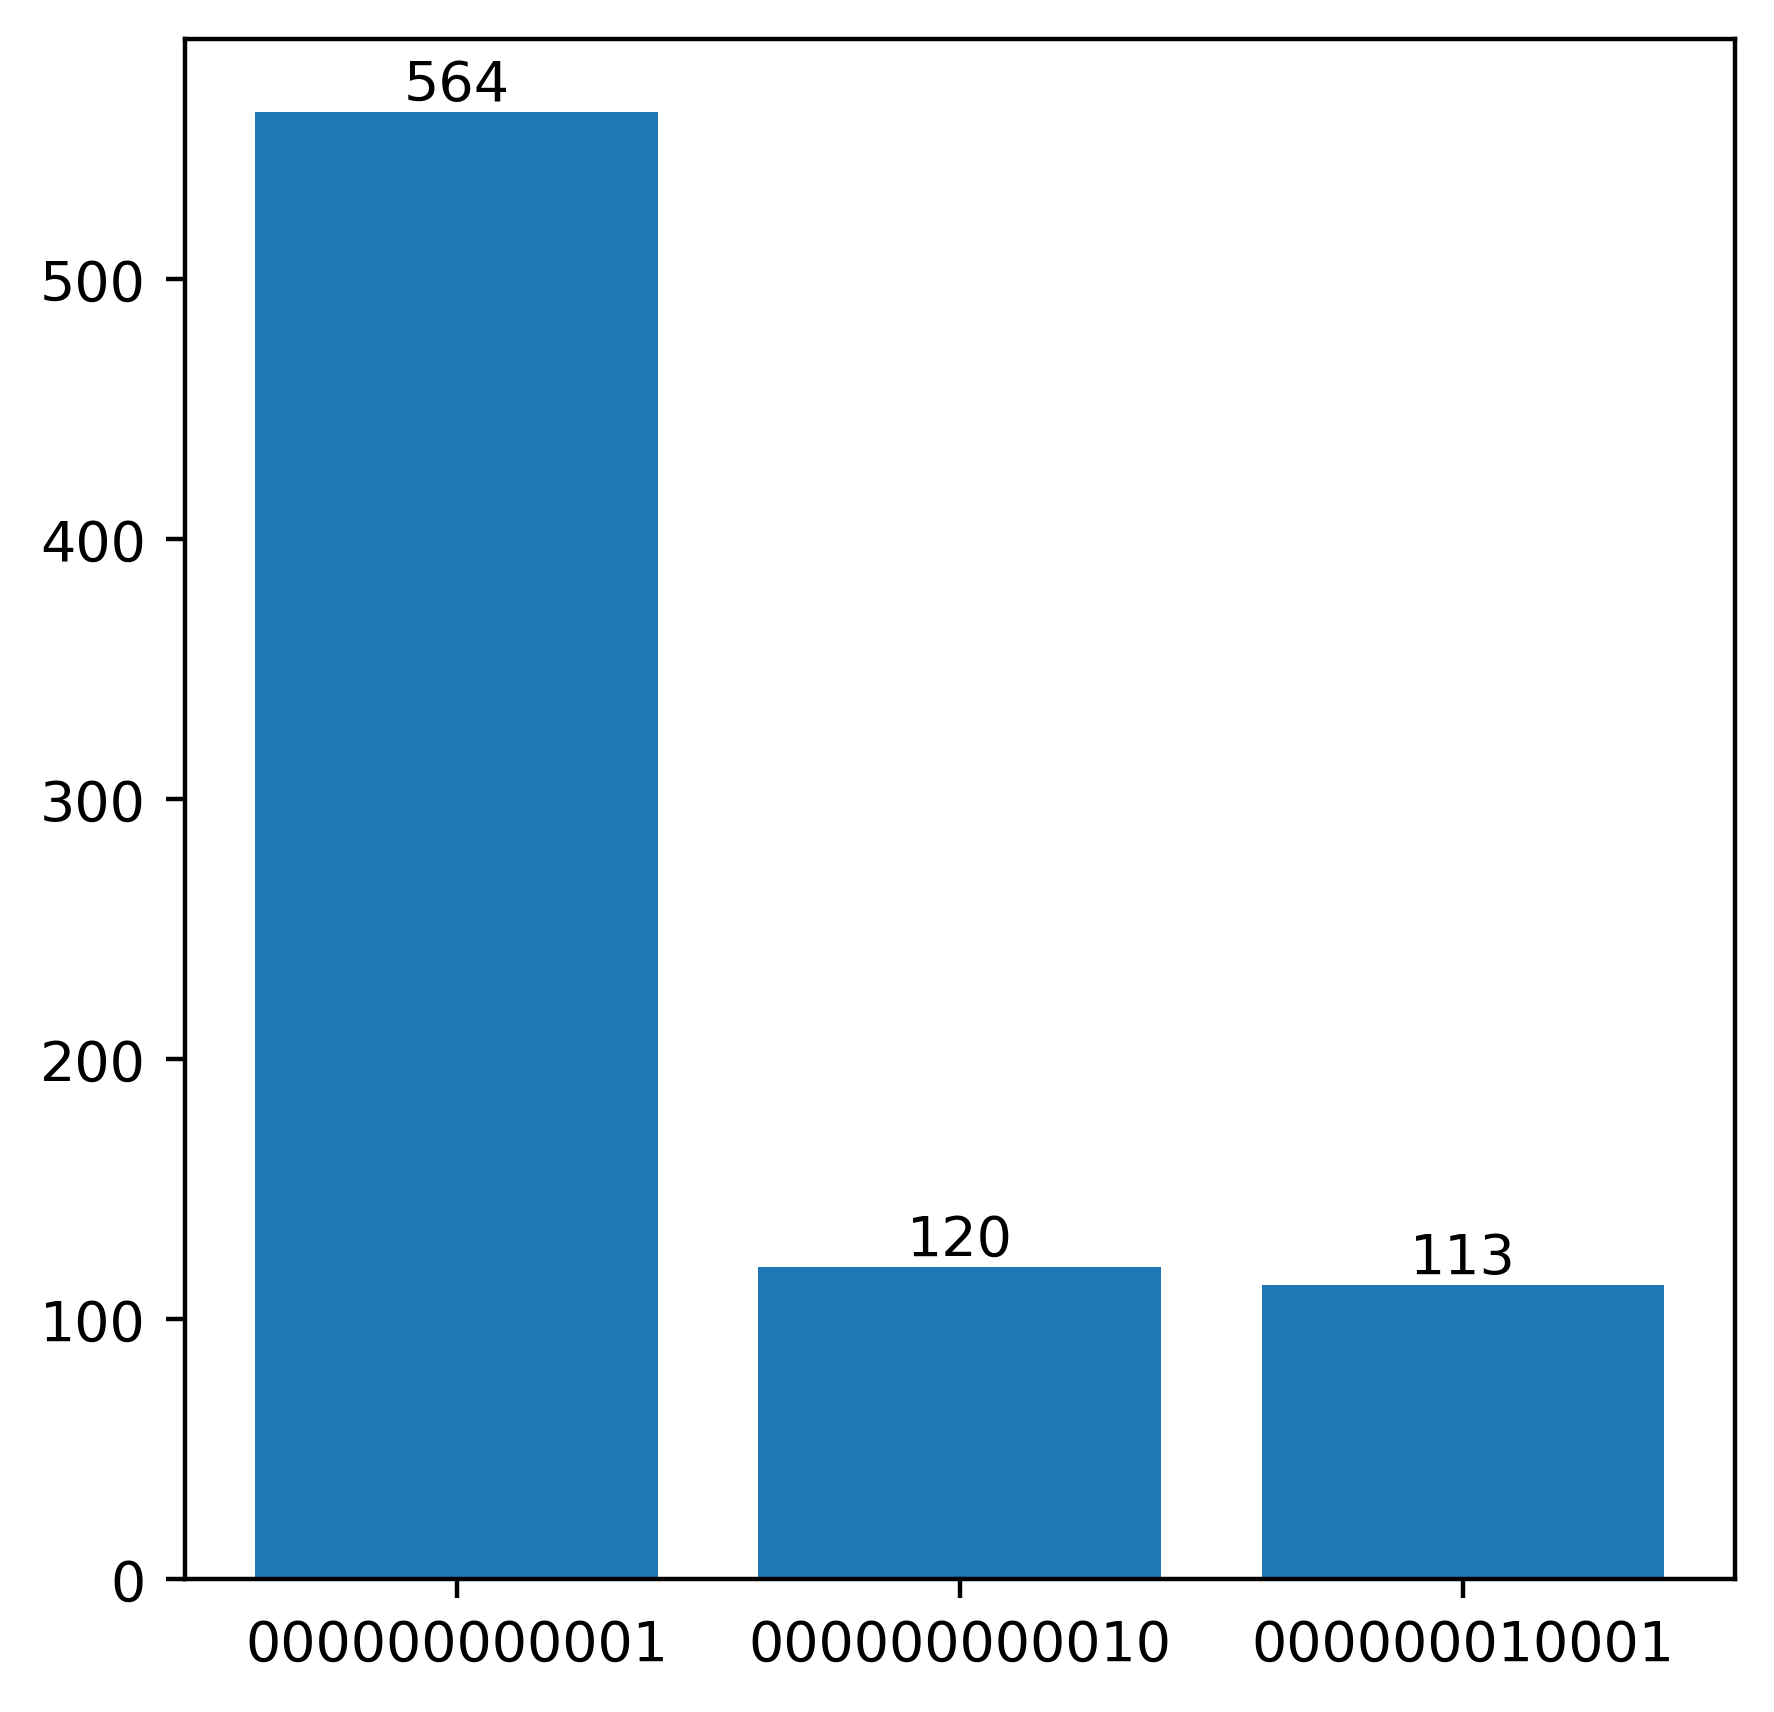

In [95]:
res_dict_12_ng = dict(list(sorted(res_vqe_12_ng_qs.binary_probabilities().items(), key=lambda item: item[1], reverse=True))[:3])
print(res_dict_12_ng)
plt.figure(figsize=(5,5), dpi=400)
round_values = [round(1000 * i) for i in res_dict_12_ng.values()]
counts = plt.bar(range(len(res_dict_12_ng)), round_values, align='center')
plt.bar_label(counts)
plt.xticks(range(len(res_dict_12_ng)), list(res_dict_12_ng.keys()))
plt.show()

In [96]:
asset_12_prices.reverse()
asset_12_prices

[11.0, 42.0, 26.0, 180.0, 179.0, 103.0, 59.0, 142.0, 111.0, 90.0, 10.0, 30.0]